In [ ]:
!nvidia-smi

In [ ]:
!pip install qiskit[visualization]
!pip install qiskit-aer-gpu
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

### Task 1 


In [28]:
import numpy as np

from qiskit import QuantumCircuit, Aer, execute, QuantumRegister 
from qiskit.circuit import ParameterVector, Parameter
from qiskit.compiler import transpile
from qiskit_textbook.tools import array_to_latex

We plan to implement the following circuit diagram. Where the combination of 1 yellow + 1 green unitary gate represents a layer. 


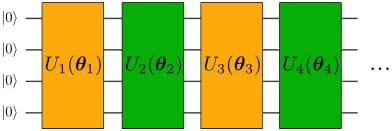

In [ ]:
num_qubits = 4
theta = ParameterVector('theta', length=num_qubits)

All the odd unitary blocks can be decomposed as:


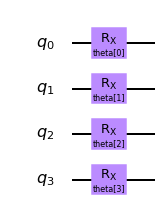

In [29]:
qc = QuantumCircuit(4)
for i in range(num_qubits):
    qc.rx(theta[i], i)
qc.draw('mpl')

All the even unitary blocks can be decomposed as: 


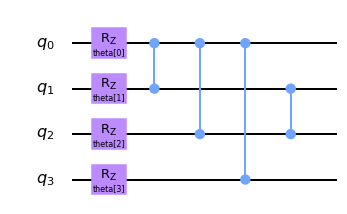

In [31]:
qc = QuantumCircuit(4)
for i in range(num_qubits):
    qc.rz(theta[i], i)
qc.cz(0, 1)
qc.cz(0, 2)
qc.cz(0, 3)
qc.cz(1, 2)

qc.draw('mpl')

$ \left| \phi \right\rangle $ is a randomly generated vector on 4 qubits.


In [58]:
phi_state = np.exp(1j*np.random.rand(num_qubits**2))
array_to_latex(phi_state, pretext="|\phi 〉 = ")

<IPython.core.display.Math object>

Let us define a Unitary Gateset which constitutes of an odd and an even unitary gate as shown below. A single gateset would act as a layer in our circuit.

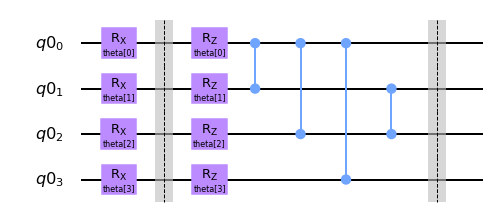

In [ ]:
U_reg = QuantumRegister(num_qubits)
U_gateset = QuantumCircuit(U_reg, name='U_gateset')

for i in range(num_qubits):
    U_gateset.rx(theta[i], i)
U_gateset.barrier()

for i in range(num_qubits):
    U_gateset.rz(theta[i], i)
U_gateset.cz(0, 1)
U_gateset.cz(0, 2)
U_gateset.cz(0, 3)
U_gateset.cz(1, 2)
U_gateset.barrier()

U_gateset.draw('mpl')

Compiling a parametrized circuit prior to parameter binding can help in reducing the compilation time of the circuit.

In [ ]:
statevector_backend = Aer.get_backend('statevector_simulator')
transpiled_qc = transpile(U_gateset, backend=statevector_backend)

We employ an evolutionary algorithm to optimize the paremeter values in the quantum circuit in order to minimize the distance between the final state $ \left| \psi(\theta) \right\rangle $ and a randomly generated state $ \left| \phi \right\rangle $. 

An evolutionary algorithm intially selects a random set of parameters as shown below.

In [ ]:
def init_pop(sol_per_pop, L):
  """Initalizes a random population of parameters"""
  population = []
  for i in range(sol_per_pop):
    population.append(2*np.pi*np.random.rand(4*L))
  return population

pop0 = init_pop(8, 2)
pop0

[array([0.85441479, 2.91687285, 5.17607191, 3.15014447, 2.93562011,
        0.95203069, 4.45243956, 3.84725297]),
 array([0.64943943, 0.72646726, 2.07725365, 6.17145479, 3.34322777,
        4.5609759 , 1.45695532, 5.20937418]),
 array([5.6752203 , 4.38728645, 4.1506588 , 3.68274813, 3.19147104,
        1.27238481, 0.43296692, 0.4965026 ]),
 array([1.50795239, 3.97870036, 6.24322132, 5.85318065, 1.40703925,
        1.77123763, 2.7385268 , 1.53891935]),
 array([5.62654566, 3.42145072, 0.2656722 , 3.43174723, 5.65061174,
        1.17010675, 4.88129745, 3.5532673 ]),
 array([0.52795316, 0.81194667, 6.25962102, 4.89691905, 1.96256235,
        3.24273847, 4.33464594, 4.77592117]),
 array([1.80866742, 2.81696801, 2.78939554, 4.19824644, 2.51225674,
        3.35639878, 1.69049218, 5.53032165]),
 array([1.28713727, 3.98279788, 0.3576358 , 4.45585485, 3.90527631,
        0.42383009, 3.7897873 , 1.54452234])]

The below function is used to generate a quantum circuit of $L$ layers and bind the parameters provided in the argument to those in the circuit.



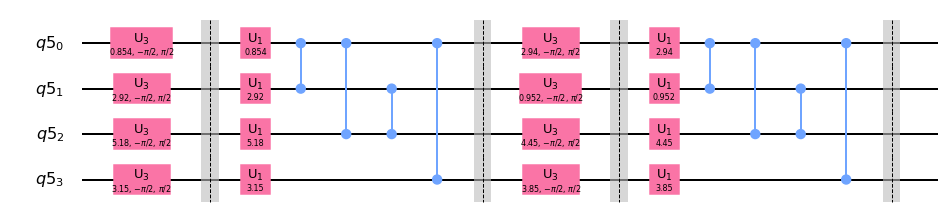

In [ ]:
def generate_qc(L, params):
  """ Generates a Quantum Circuit with L-layers and binds the parameters with those in the argument"""
    params_split = np.split(params, L)
    u_layers = [transpiled_qc.bind_parameters({theta: param}) for param in params_split]

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    for i in range(L):
        qc.append(u_layers[i].to_instruction(), qr)

    return qc

qc = generate_qc(2, pop0[0])

qc.decompose().draw('mpl')

The fitness value is taken to be the negative of minimum distance ($\epsilon$), which is given by: $$\epsilon = min_\theta || \left| \psi(\theta) \right\rangle - \left| \phi \right\rangle ||$$  Fitness values of all the parameters are found and a set of those which have the highest values ($i.e.$ minimum $\epsilon$ value) are chosen to become the parents for the next generation. 

In [ ]:
def cal_fitness(population, L):
  """ Calculates the fitness of the population """
  fitness = []

  for params in population:
    qc = generate_qc(L, params)
    final_state = execute(qc, 
                          statevector_backend, 
                          backend_options={"method": "statevector_gpu"}).result().get_statevector()
    fit = np.sum(np.abs(final_state-phi_state)**2)
    fitness.append(-fit)      
    
  return fitness

fit0 = cal_fitness(pop0, L)
fit0

[-14.850305296331324,
 -16.17747495977596,
 -17.206373473386996,
 -17.988750822035527,
 -19.47880095756584,
 -17.075256487474505,
 -18.394708435746836,
 -16.214468443304554]

In [ ]:
def select_mating_pool(population, fitness, num_parents):
    """Selects the best individuals in the current generation as parents"""
    parents = []
    for parent_num in range(num_parents):
        max_fitness_idx = fitness.index(max(fitness))
        parents.append(population[max_fitness_idx])
        fitness[max_fitness_idx] = -999
    return parents

mpool = select_mating_pool(pop0, fit0, sol_per_pop//2)
mpool

[array([0.85441479, 2.91687285, 5.17607191, 3.15014447, 2.93562011,
        0.95203069, 4.45243956, 3.84725297]),
 array([0.64943943, 0.72646726, 2.07725365, 6.17145479, 3.34322777,
        4.5609759 , 1.45695532, 5.20937418]),
 array([1.28713727, 3.98279788, 0.3576358 , 4.45585485, 3.90527631,
        0.42383009, 3.7897873 , 1.54452234]),
 array([0.52795316, 0.81194667, 6.25962102, 4.89691905, 1.96256235,
        3.24273847, 4.33464594, 4.77592117])]

The selected parents generate offsprings by crossover and mutation. Crossover involves mixing of genes between two parents and mutation involves mutating a random gene in the generated offspring.

In [ ]:
def crossover(parents, offspring_size):
  """Generates offsprings by crossover between parents"""
    offsprings = []
    # The point at which crossover takes place between two parents
    crossover_point = num_qubits//2

    for i in range(sol_per_pop//2):
        # Index of the first parent to mate
        parent1_idx = i%len(parents)
        # Index of the second parent to mate
        parent2_idx = (i+1)%len(parents)
        offspring = np.concatenate((parents[parent1_idx][:crossover_point],parents[parent2_idx][crossover_point:]), axis=0)
        offsprings.append(offspring)

    return offsprings

ofc = crossover(mpool, 2)
ofc

[array([0.85441479, 2.91687285, 2.07725365, 6.17145479, 3.34322777,
        4.5609759 , 1.45695532, 5.20937418]),
 array([0.64943943, 0.72646726, 0.3576358 , 4.45585485, 3.90527631,
        0.42383009, 3.7897873 , 1.54452234]),
 array([1.28713727, 3.98279788, 6.25962102, 4.89691905, 1.96256235,
        3.24273847, 4.33464594, 4.77592117]),
 array([0.52795316, 0.81194667, 5.17607191, 3.15014447, 2.93562011,
        0.95203069, 4.45243956, 3.84725297])]

In [ ]:
def mutation(offspring_crossover):
    """Creates mutation at a random gene in the offsprings"""
    for idx in range(len(offspring_crossover)):
        # The random value to be added to the gene.
        random_idx = np.random.randint(num_qubits)
        random_value =  2*np.pi*np.random.rand(1)
        offspring_crossover[idx][random_idx] = random_value
    return offspring_crossover

ofm = mutation(ofc)
ofm

[array([0.85441479, 1.16009666, 2.07725365, 6.17145479, 3.34322777,
        4.5609759 , 1.45695532, 5.20937418]),
 array([0.64943943, 0.72646726, 0.3576358 , 2.3671659 , 3.90527631,
        0.42383009, 3.7897873 , 1.54452234]),
 array([1.28713727, 1.78482693, 6.25962102, 4.89691905, 1.96256235,
        3.24273847, 4.33464594, 4.77592117]),
 array([1.58647135, 0.81194667, 5.17607191, 3.15014447, 2.93562011,
        0.95203069, 4.45243956, 3.84725297])]

The next generation consists of parents and offsprings from the previous generation. This process repeats for a number of generations usually after which there is not much difference in the fitness of individuals.

In [ ]:
L = 2
sol_per_pop = 20
num_generations = 50

def genetic_algorithm(sol_per_pop, num_generations, L, verbose = True):
  """Implements the genetic algorithm"""
    fitness_g = []
    new_population = init_pop(sol_per_pop, L)
    num_parents_mating = sol_per_pop // 2

    best_fitness = -99

    for generation in range(num_generations):
    
    # Measuring the fitness of each chromosome in the population.
        fitness = cal_fitness(new_population, L)

    # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, num_parents_mating)

    # Generating next generation using crossover.
        offspring_crossover = crossover(parents, offspring_size=sol_per_pop-len(parents))

    # Adding some variations to the offsrping using mutation.
        offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
        new_population = parents + offspring_mutation

        fit_gen = np.max(fitness)

    # Getting the best solution 
        if fit_gen > best_fitness:
            best_fitness = fit_gen
            best_fitness_idx = np.where(fitness == fit_gen)[0][0]
            best_sol = new_population[best_fitness_idx]   

        if verbose == True:
            fitness_g.append(fit_gen)
    
    if verbose == True:
        return best_fitness, best_sol, fitness_g
    else:
        return best_fitness, best_sol

best_fitness, best_sol, fitness_g = genetic_algorithm(sol_per_pop, num_generations, L)

In [ ]:
print('Fitness :', best_fitness)
print('Parameters :', best_sol)

Fitness : -10.734620703206373
Parameters : [0.89763791 4.44366824 2.09860692 4.47360075 0.21737684 3.17692573
 4.03385876 0.48021399]


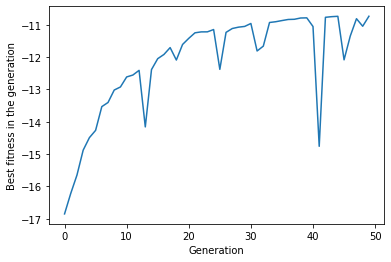

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Generation")
plt.ylabel("Best fitness in the generation")
plt.plot(fitness_g)

#### Plotting the number of layers ($L$) against the minimum distance ($\epsilon$)

In [ ]:
# %%time
sol_per_pop = 20
num_generations = 300
L = 10

y = []
for l in range(1,L):
    qr = QuantumRegister(4, 'q')
    qc = QuantumCircuit(qr)

    best_fitness, best_sol = genetic_algorithm(sol_per_pop, num_generations, L, verbose = False)
    y.append(best_fitness)    
    # print("Executed Layer: "+l)

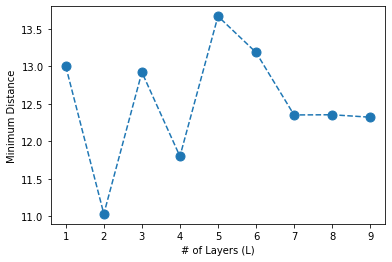

In [27]:
plt.xlabel("# of Layers (L)")
plt.ylabel("Minimum Distance")
plt.plot(list(range(1,L)), -1*np.array(y), linestyle='dashed', marker='o', markersize=9) 